In [1]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_excel('http://dataevents.hu/202303/filedataevents/competition_table.xlsx', engine='openpyxl')

In [4]:
df.head()

,match_id,season,div,odds_home_team_win,odds_draw,odds_away_team_win,home_team_match_nr,home_team_goal_roll1_sum,home_team_goal_roll2_sum,home_team_goal_roll3_sum,...,odds_away_team_draw_roll4_mean,odds_away_team_defeat_roll1_mean,odds_away_team_defeat_roll2_mean,odds_away_team_defeat_roll3_mean,odds_away_team_defeat_roll4_mean,away_team_point_mean,away_team_expected_point_mean,home_win_flag,draw_flag,away_win_flag
0,0,2008-2009,div0,1.73,3.5,5.00,5,3,7,8,...,3.825,11.00,7.665,6.377,5.908,0.500,3.0,0,0,1
1,1,2008-2009,div0,1.25,5.5,12.00,7,0,2,5,...,3.582,2.10,2.250,2.833,2.475,0.333,0.0,0,1,0
2,2,2008-2009,div0,1.57,3.8,5.75,9,1,4,4,...,3.525,6.75,4.275,3.883,3.638,0.750,1.5,1,0,0
3,3,2008-2009,div0,1.17,7.0,15.00,11,2,6,7,...,3.975,4.20,2.750,2.333,2.550,0.600,0.0,1,0,0
4,4,2008-2009,div0,1.17,7.0,15.00,14,2,4,7,...,3.925,3.10,2.175,2.050,2.015,0.833,0.0,1,0,0


In [5]:
df = df[(df.odds_home_team_win != 0) & (df.odds_draw != 0) & (df.odds_away_team_win != 0)]

In [6]:
df.shape

(64159, 167)

In [6]:
df.season.value_counts()

2021-2022    6534
2020-2021    6368
2018-2019    5913
2017-2018    5730
2019-2020    5670
2013-2014    3848
2014-2015    3846
2015-2016    3845
2010-2011    3842
2012-2013    3841
2008-2009    3818
2009-2010    3799
2011-2012    3767
2016-2017    3338
Name: season, dtype: int64

In [7]:
df[['odds_home_team_win', 'odds_draw', 'odds_away_team_win', 'home_win_flag', 'draw_flag', 'away_win_flag']].head(20)

,odds_home_team_win,odds_draw,odds_away_team_win,home_win_flag,draw_flag,away_win_flag
0,1.73,3.50,5.00,0,0,1
1,1.25,5.50,12.00,0,1,0
2,1.57,3.80,5.75,1,0,0
3,1.17,7.00,15.00,1,0,0
4,1.17,7.00,15.00,1,0,0
5,1.62,3.80,5.50,1,0,0
6,1.44,4.00,8.00,1,0,0
7,1.25,5.50,12.00,0,0,1
8,1.33,5.00,9.00,1,0,0
9,1.14,7.50,17.00,1,0,0


In [60]:
df[['home_win_flag', 'draw_flag', 'away_win_flag']].sum()

home_win_flag    28211
draw_flag        16796
away_win_flag    19152
dtype: int64

In [7]:
df['probable_event'] = df[['odds_home_team_win', 'odds_draw', 'odds_away_team_win']].idxmin(axis = 1)

In [25]:
df.groupby('probable_event')['match_id'].count()

probable_event
odds_away_team_win    18054
odds_draw                63
odds_home_team_win    46042
Name: match_id, dtype: int64

In [25]:
df.groupby('probable_event')['match_id'].count()

probable_event
odds_away_team_win    18054
odds_draw                63
odds_home_team_win    46042
Name: match_id, dtype: int64

In [8]:
df['prob_home_win'] = 1 / df.odds_home_team_win
df['prob_draw'] = 1 / df.odds_draw
df['prob_away_win'] = 1 / df.odds_away_team_win

In [59]:
df['home_win_excess_prob'] = df['prob_home_win'] - df['prob_away_win'] -df['prob_draw']

In [60]:
df['away_win_excess_prob'] = df['prob_away_win'] - df['prob_home_win'] - df['prob_draw']

In [61]:
df['draw_excess_prob'] = df['prob_draw'] - df['prob_home_win'] - df['prob_away_win'] 

In [10]:
df['home_win_predicted'] = df.probable_event == 'odds_home_team_win'

df.home_win_predicted = df.home_win_predicted.astype('int')

In [17]:
df['away_win_predicted'] = df.probable_event == 'odds_away_team_win'
df.away_win_predicted = df.away_win_predicted.astype('int')

In [18]:
df['draw_predicted'] = df.probable_event == 'odds_draw'
df.draw_predicted = df.draw_predicted.astype('int')

In [41]:
df_f = df.copy()

In [46]:
df_f.season.unique()

array(['2008-2009', '2009-2010', '2010-2011', '2011-2012', '2012-2013',
       '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018',
       '2018-2019', '2019-2020', '2020-2021', '2021-2022'], dtype=object)

In [45]:
df = df[df.season.isin(['2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022'])]

### Analyzing Home Wins

In [11]:
df[['odds_home_team_win', 'odds_draw', 'odds_away_team_win', 'home_win_flag', 'draw_flag', 'away_win_flag', 'home_win_predicted']]

,odds_home_team_win,odds_draw,odds_away_team_win,home_win_flag,draw_flag,away_win_flag,home_win_predicted
0,1.73,3.50,5.00,0,0,1,1
1,1.25,5.50,12.00,0,1,0,1
2,1.57,3.80,5.75,1,0,0,1
3,1.17,7.00,15.00,1,0,0,1
4,1.17,7.00,15.00,1,0,0,1
...,...,...,...,...,...,...,...
64161,3.80,3.71,1.90,0,0,1,0
64162,3.62,3.42,2.04,0,0,1,0
64163,5.51,4.06,1.59,0,0,1,0
64164,3.83,3.76,1.87,0,0,1,0


In [12]:
tn, fp, fn, tp = confusion_matrix(df.home_win_flag, df.home_win_predicted).ravel()

In [13]:
pd.pivot_table(df, values='draw_flag', index=['home_win_predicted'],
                    columns=['home_win_flag'], aggfunc='count').applymap("{:,.0f}".format)

home_win_flag,0,1
home_win_predicted,,
0,"13,392","4,725"
1,"22,556","23,486"


In [15]:
df.home_win_flag.sum() / df.shape[0]

0.43970448417213487

In [16]:
df.home_win_predicted.sum() / df.shape[0]

0.717623404354806

In [15]:
23490 / (23490 + 22559)

0.510108797150861

In [16]:
pd.DataFrame(confusion_matrix(df.home_win_flag, df.home_win_predicted))

,0,1
0,13392,22556
1,4725,23486


In [17]:
print(tn, fp, fn, tp)

13392 22556 4725 23486


In [18]:
TPR = tp / (tp + fn)
TNR = tn / (tn + fp)
FPR = 1- TNR
FNR = 1 - TPR

In [19]:
print('TPR:', TPR)
print('TNR:', TNR)
print('FPR:', FPR)
print('FNR:', FNR)
print('Accuracy:', (tp + tn)/df.shape[0])

TPR: 0.8325121406543546
TNR: 0.37253811060420605
FPR: 0.627461889395794
FNR: 0.16748785934564536
Accuracy: 0.5747907542199847


#### Odds vs outcomes

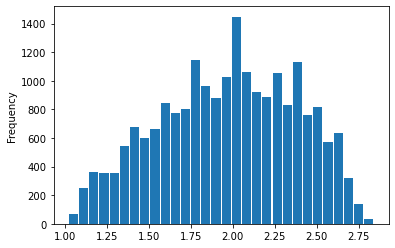

In [47]:
df[df.home_win_predicted == 1]['odds_home_team_win'].plot(kind = 'hist', bins = 30, rwidth = 0.9);

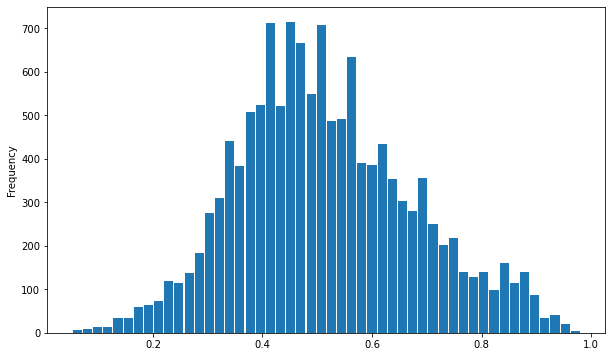

In [48]:
df[df.home_win_flag == 1]['prob_home_win'].plot(kind = 'hist', bins = 50, rwidth = 0.9, figsize = (10,6));

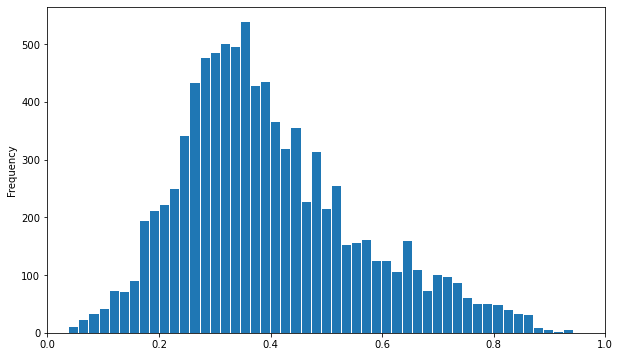

In [49]:
df[df.away_win_flag == 1]['prob_away_win'].plot(kind = 'hist', bins = 50, rwidth = 0.9, figsize = (10,6), xlim = (0, 1));

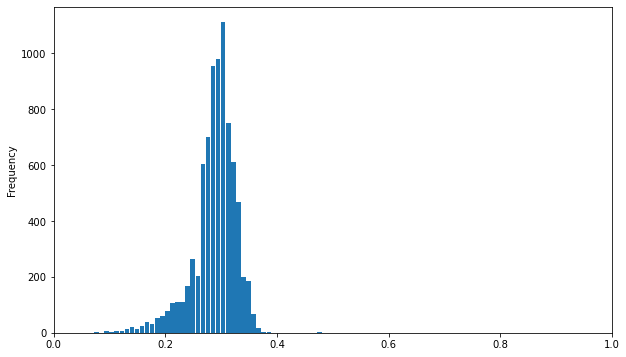

In [50]:
df[df.draw_flag == 1]['prob_draw'].plot(kind = 'hist', bins = 50, rwidth = 0.9, figsize = (10,6), xlim = (0, 1));

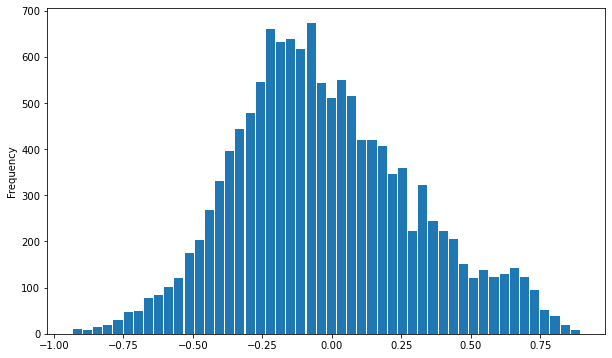

In [62]:
df[df.home_win_flag == 1]['home_win_excess_prob'].plot(kind = 'hist', bins = 50, rwidth = 0.9, figsize = (10,6));

In [66]:
df[df['home_win_excess_prob'] > -0.01]['home_win_flag'].mean()

0.6335548172757475

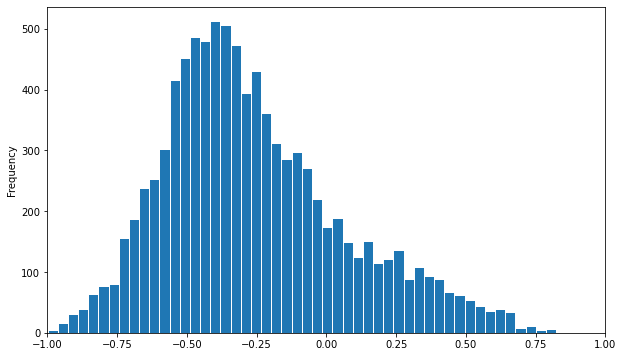

In [67]:
df[df.away_win_flag == 1]['away_win_excess_prob'].plot(kind = 'hist', bins = 50, rwidth = 0.9, figsize = (10,6), xlim = (-1, 1));

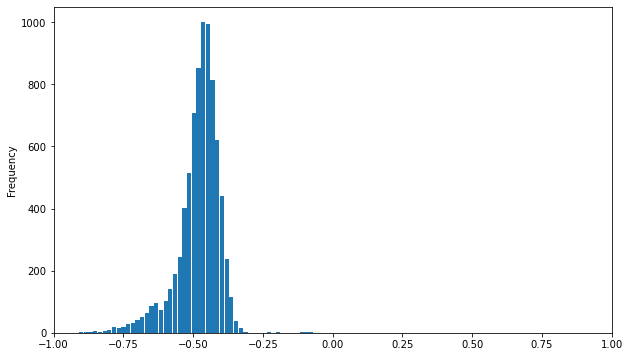

In [64]:
df[df.draw_flag == 1]['draw_excess_prob'].plot(kind = 'hist', bins = 50, rwidth = 0.9, figsize = (10,6), xlim = (-1, 1));

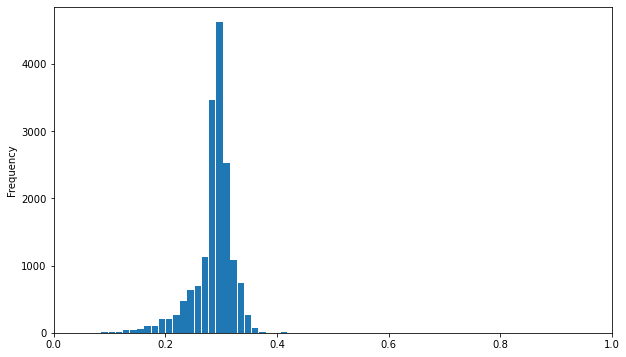

In [34]:
df[df.draw_flag == 1]['prob_draw'].plot(kind = 'hist', bins = 50, rwidth = 0.9, figsize = (10,6), xlim = (0, 1));

In [57]:
df[df.home_win_flag == 1]['home_win_excess_prob'].describe(percentiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.90, 0.99])

count    13058.000000
mean         0.244453
std          0.286094
min         -0.810880
1%          -0.471042
10%         -0.109414
25%          0.063336
50%          0.235090
75%          0.436994
90%          0.624183
99%          0.848423
max          0.950980
Name: home_win_excess_prob, dtype: float64

In [56]:
df[df.draw_flag == 1]['home_win_excess_prob'].describe(percentiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.90, 0.99])

count    7987.000000
mean        0.111024
std         0.265395
min        -0.853908
1%         -0.603047
10%        -0.226190
25%        -0.043862
50%         0.117053
75%         0.276316
90%         0.437400
99%         0.720137
max         0.924665
Name: home_win_excess_prob, dtype: float64

In [58]:
df[df.away_win_flag == 1]['home_win_excess_prob'].describe(percentiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.90, 0.99])

count    9170.000000
mean       -0.022069
std         0.306667
min        -0.906414
1%         -0.757362
10%        -0.467208
25%        -0.212605
50%         0.007916
75%         0.189512
90%         0.347733
99%         0.660631
max         0.887316
Name: home_win_excess_prob, dtype: float64

In [70]:
df.groupby('probable_event').agg(
    {'home_win_flag': [np.mean],
    'draw_flag': [np.mean],
     'away_win_flag': [np.mean]
    })

,home_win_flag,draw_flag,away_win_flag
,mean,mean,mean
probable_event,,,
odds_away_team_win,0.257709,0.261279,0.481013
odds_draw,0.264706,0.411765,0.323529
odds_home_team_win,0.509456,0.265450,0.225093


#### Probs vs probs

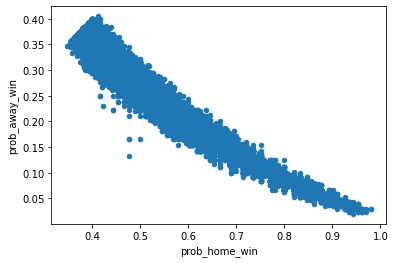

In [50]:
df[df.home_win_predicted == 1].plot(kind = 'scatter', x = 'prob_home_win', y = 'prob_away_win');

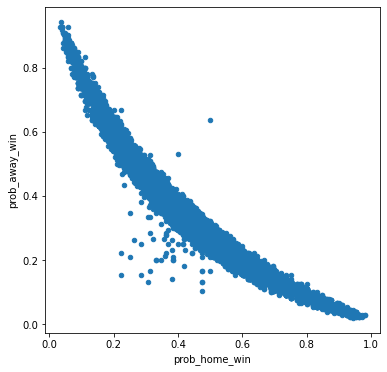

In [52]:
df.plot(kind = 'scatter', x = 'prob_home_win', y = 'prob_away_win', figsize = (6,6));

#### Strong Home Win Conviction

In [22]:
pd.pivot_table(df[df.odds_home_team_win < 2], values='draw_flag', index=['home_win_predicted'],
                    columns=['home_win_flag'], aggfunc='count').applymap("{:,.0f}".format)

home_win_flag,0,1
home_win_predicted,,
1,"8,680","13,703"


In [23]:
13707 / (13707 + 8683)

0.6121929432782492

#### Calibration plots

***home wins***

In [71]:
prob_true, prob_pred = calibration_curve(df.home_win_flag, df.prob_home_win, n_bins=50, normalize = True)

''

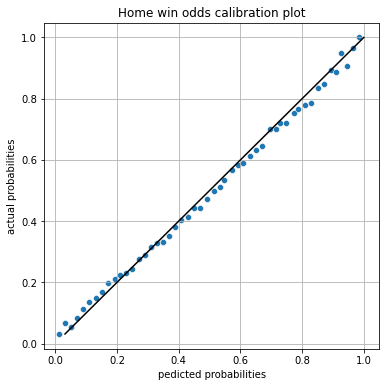

In [72]:
fig, ax = plt.subplots(figsize=(6, 6))
p1 = sns.scatterplot(y = prob_true, x = prob_pred, ax=ax)
p2 = sns.lineplot(y = prob_true, x = prob_true, color='k', ax=ax)
plt.title("Home win odds calibration plot")
plt.xlabel('pedicted probabilities')
plt.ylabel('actual probabilities')
plt.grid('both')
;

***away wins***

In [73]:
prob_true, prob_pred = calibration_curve(df.away_win_flag, df.prob_away_win, n_bins=50, normalize = True)

''

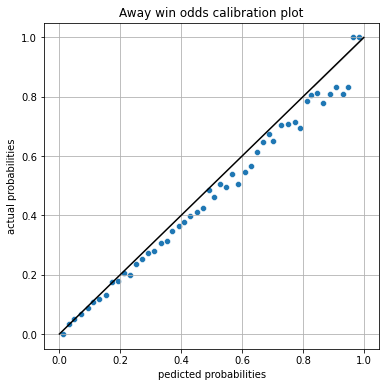

In [74]:
fig, ax = plt.subplots(figsize=(6, 6))
p1 = sns.scatterplot(y = prob_true, x = prob_pred, ax=ax)
p2 = sns.lineplot(y = prob_true, x = prob_true, color='k', ax=ax)
plt.title("Away win odds calibration plot")
plt.xlabel('pedicted probabilities')
plt.ylabel('actual probabilities')
plt.grid('both')
;

***draws***

In [65]:
prob_true, prob_pred = calibration_curve(df.draw_flag, df.prob_draw, n_bins=50, normalize = True)

''

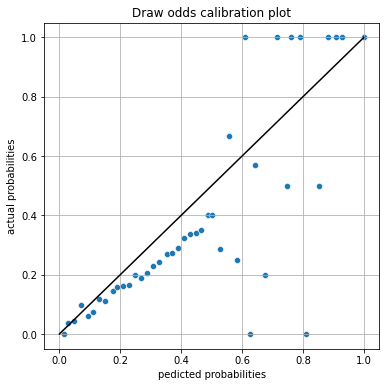

In [69]:
fig, ax = plt.subplots(figsize=(6, 6))
p1 = sns.scatterplot(y = prob_true, x = prob_pred, ax=ax)
p2 = sns.lineplot(y = prob_true, x = prob_true, color='k', ax=ax)
plt.title("Draw odds calibration plot")
plt.xlabel('pedicted probabilities')
plt.ylabel('actual probabilities')
plt.grid('both')
;

$\hat{y}=\frac{1}{1+e^{-(\mathbf{w}^{T}\mathbf{x}+b)}}$

#### Draws and Away Wins

In [21]:
pd.pivot_table(df, values='away_win_flag', index=['draw_predicted'],
                    columns=['draw_flag'], aggfunc='count').applymap("{:,.0f}".format)

draw_flag,0,1
draw_predicted,,
0,"47,331","16,765"
1,32,31


In [22]:
df.draw_flag.sum() / df.shape[0]

0.2617871226172478

In [23]:
df.draw_predicted.sum() / df.shape[0]

0.000981935503982294

#### Other Variables

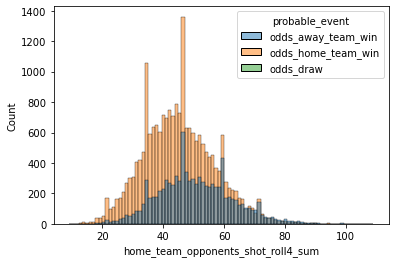

In [77]:
sns.histplot(data = df, x = 'home_team_opponents_shot_roll4_sum', hue = 'probable_event');

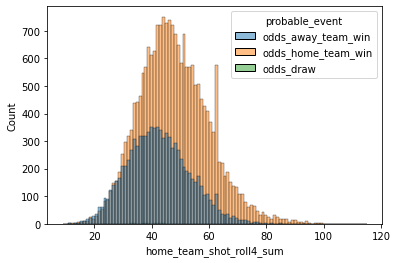

In [76]:
sns.histplot(data = df, x = 'home_team_shot_roll4_sum', hue = 'probable_event');

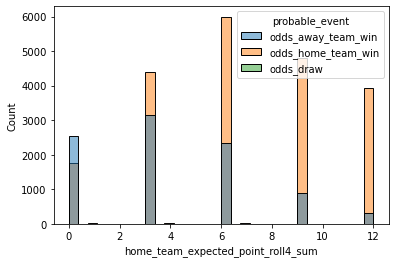

In [78]:
sns.histplot(data = df, x = 'home_team_expected_point_roll4_sum', hue = 'probable_event');